In [1]:
pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7909 sha256=b06c87ec6afbeb262c4d6ce2909715fe3bb2dc7df9ccd0e7524463d2df465b08
  Stored in directory: c:\users\turih\appdata\local\pip\cache\wheels\1a\ce\ad\d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy
Note: you may need to restart the kernel to use updated packages.


--- 1524.1293470859528 seconds ---


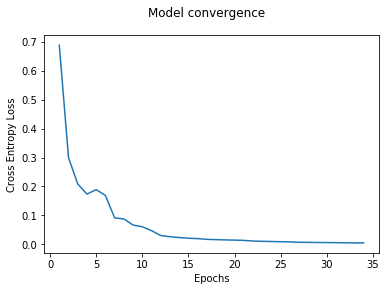

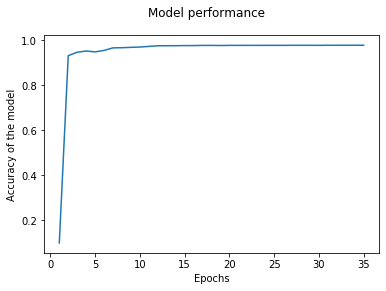

In [43]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

training_images_file = 'train-images.idx3-ubyte'
training_labels_file = 'train-labels.idx1-ubyte'
test_images_file = 't10k-images.idx3-ubyte'
test_labels_file = 't10k-labels.idx1-ubyte'

training_data = idx2numpy.convert_from_file(training_images_file)
training_labels = idx2numpy.convert_from_file(training_labels_file)
test_data = idx2numpy.convert_from_file(test_images_file)
test_labels = idx2numpy.convert_from_file(test_labels_file)
# training_data is now a np.ndarray type of object of shape 60000, 28, 28 
# training_labels is just a 1D array of numbers that label the pictures

def plot_results(data, col, probs, n_per_row=4, title=None):
    # Plots the given images and classification probability distribution given by the model #
    l = len(data)
    if l % n_per_row != 0:
        fig, axs = plt.subplots(l//n_per_row+1,l%n_per_row*2)
    else:
        fig, axs = plt.subplots(l//n_per_row,n_per_row*2)
    fig.set_figwidth(15)
    fig.set_figheight(l//n_per_row*2)
    if title != None:
        fig.suptitle(title)
    if (l - 1) // n_per_row == 0: 
        for i in range(l):
            if col[i]: color = 'blue'
            else: color = 'red'
            axs[i%n_per_row*2].bar((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), probs[i], tick_label=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), color=color) 
            axs[i%n_per_row*2].set_ylim(0, 1)
            axs[i%n_per_row*2+1].imshow(data[i], cmap=plt.cm.binary)
            axs[i%n_per_row*2+1].axis('off')
    else:
        for i in range(l):
            if col[i]: color = 'blue'
            else: color = 'red'
            axs[i//n_per_row, i%n_per_row*2].bar((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), probs[i], tick_label=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), color=color)
            axs[i//n_per_row, i%n_per_row*2].set_ylim(0, 1)
            axs[i//n_per_row, i%n_per_row*2+1].imshow(data[i], cmap=plt.cm.binary)
            axs[i//n_per_row, i%n_per_row*2+1].axis('off')

def plot(y, scale, xtitle, ytitle, suptitle, fig_count, start=1):
    # For plotting convergence and performance stats #
    plt.figure(fig_count)
    plt.plot(np.array(range(start, len(y)+1))*scale, y)
    plt.suptitle(suptitle)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    fig_count += 1
    return fig_count
    
def turn_labels_to_vectors(labels):
    # Turns the labels to output vector arrays #
    transformation = {0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
                      2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                      4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      6: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 7: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                      8: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
    return np.array([transformation[e] for e in labels]) 

def sigmoid(x):
    # Computes the sigmoid function for the array #
    return 1 / (1 + np.exp(-x))

def softmax(x):
    # Computes the softmax function for the array #
    return np.einsum('ab,a->ab', np.exp(x), np.sum(np.exp(x), axis=1) ** (-1))

def mean_square_error(o, t):
    # Returns the total normalized mean squared error #
    return 0.5 * np.sum((o - t) ** 2) / len(o)

def cross_entropy_loss(o, t):
    # Returns normalized total cross entropy loss #
    return - np.sum(t * np.log(o)) / len(o)

def sigmoid_grad(sigmoid):
    # Returns the gradients of the sigmoid function output arrays #
    return sigmoid * (1 - sigmoid)

def softmax_grad(softmax):
    # Returns the Jakobians of the softmax function output arrays #
    s = softmax.reshape(len(softmax),-1,1)
    return [np.diagflat(m) for m in s] - np.einsum('abc,adc->abd', s, s)

def feedforward(inputs, wab):
    # Computes the output of the NN #
    l = len(inputs)
    outputs = [inputs]
    for i in range(len(wab)):
        # Einsum multiplies every of the 60k vectors at a certain layer
        # (with 1s attached at the end due to the bias == weight notation) by the corresponding weight matrix
        outputs.append(sigmoid(np.einsum('ab,bc->ac', np.c_[outputs[-1], np.ones(l)], wab[i])))
    return outputs[1::]

def backprop(i, t, o, wab, loss_f):
    # Computes averaged corrections for weights and biases using the steepest gradient descent algorithm #
    l = len(i)
    delta, delta_wab = [], []
    # Error (delta) backpropagation and gradient (weight shift) calculation 
    # Plenty of resources online that derive the formalism (for example https://brilliant.org/wiki/backpropagation/)
    if loss_f == 1:
        delta.append(np.einsum('abc,ab->ac', softmax_grad(o[-1]), (o[-1]-t)))
    elif loss_f == 2:
        delta.append(o[-1] - t)
    for j in range(1, len(wab)):
        delta_wab.append(np.einsum('ab,ac->cb', delta[-1], np.c_[o[-(1+j)], np.ones(l)]) / l)
        delta.append(sigmoid_grad(o[-(1+j)]) * np.einsum('ab,cb->ac', delta[-1], np.delete(wab[-j], -1, 0)))
    delta_wab.append(np.einsum('ab,ac->cb', delta[-1], np.c_[i, np.ones(l)]) / l)
    return delta_wab[::-1]

def train_model(data, labels, n_hidden, loss_f=2, # loss_f = 1 => MSE, loss_f = 2 => CEL
                init_wab=None, sigma_init=0.01, max_it=50, eps=0.005, max_it_in = 20,
                batch_size=100, # Divisor of len(data)
                eta=0.1, alpha=0.9, eta_decay=0.5, alpha_decay=0.5, degen=5, autosave=1):
    # Optimizes the model parameters to distinguish the digits #
    
    # Reshaping input matrices to vectors, normalizing and shifting the pixel values so that all inputs ∈ [-0.5, 0.5]
    inputs = np.reshape(data, [len(data), -1]) / 255 - 0.5
    correct_outputs = turn_labels_to_vectors(labels)
    
    # initializing random weights and biases == wab
    if init_wab == None:
        if len(n_hidden) == 0:
            wab = [np.random.normal(scale=sigma_init, size=(len(inputs[0])+1, len(correct_outputs[0])))]
        else:
            wab = ([np.random.normal(scale=sigma_init, size=(len(inputs[0])+1, n_hidden[0]))] +
                   [np.random.normal(scale=sigma_init, size=(n_hidden[i]+1, n_hidden[i+1])) for i in range(len(n_hidden)-1)] +
                   [np.random.normal(scale=sigma_init, size=(n_hidden[-1]+1, len(correct_outputs[0])))])
    else: wab = init_wab
        
    n_batches = len(inputs) // batch_size
    delta_previous_wab, error, err, wabs, it = [0] * len(wab), [eps + 1], eps + 1, [], 0
    
    # Outter loop
    while error[-1] > eps:
        it += 1
        layer_outputs = feedforward(inputs, wab)
        if loss_f == 1:
            error.append(mean_square_error(layer_outputs[-1], correct_outputs))
        elif loss_f == 2:
            error.append(cross_entropy_loss(layer_outputs[-1], correct_outputs))
        #print(error[-1])
        if it % autosave == 0:
            np.save('output/wabs'+str(it), wab)
            wabs.append(wab)
            
        # Inner loop
        for b in range(n_batches):
            it_in = 0
            while err > eps:
                it_in += 1
                layer_outputs = feedforward(inputs[b*batch_size:(b+1)*batch_size], wab)
                delta_wab = backprop(inputs[b*batch_size:(b+1)*batch_size], correct_outputs[b*batch_size:(b+1)*batch_size],
                                     layer_outputs, wab, loss_f)
                wab = [wab[w] - eta * delta_wab[w] - alpha * delta_previous_wab[w] for w in range(len(wab))] 
                delta_previous_wab = delta_wab
                if loss_f == 1:
                    err = mean_square_error(layer_outputs[-1], correct_outputs[b*batch_size:(b+1)*batch_size])
                elif loss_f == 2:
                    err = cross_entropy_loss(layer_outputs[-1], correct_outputs[b*batch_size:(b+1)*batch_size])
                #print(err)
                if it_in == max_it_in:
                    break
            err = eps + 1
        
        if it % degen == 0:
            eta, alpha = eta_decay * eta, alpha_decay * alpha # eta == learning rate, alpha == momentum 
        if it == max_it:
            break
            
    wabs.append(wab)
    np.save('output/wabs_final', wab)
    np.savetxt('output/error.csv', error, delimiter=',')
    return error, wabs
        
def test_model(data, labels, wab):
    # Tests the model using the test data #
    # I consider the model to pass the test if the correct number has the highest probability in the output
    inputs = np.reshape(data, [len(data), -1]) / 255 - 0.5
    layer_outputs = feedforward(inputs, wab)
    predictions = labels == np.argmax(layer_outputs[2], axis=1)
    return (layer_outputs[2], predictions, np.sum(predictions) / len(predictions))

def main():
    # Main function #
    errors, wabs = train_model(training_data, training_labels,
                            #init_wab=np.load('output/5k_batch/wabs_final.npy', allow_pickle=True),
                            n_hidden=[200, 50])
    fc = plot(errors[1::], 1, "Epochs", "Cross Entropy Loss", "Model convergence", 1)
    
    test_results = [test_model(test_data, test_labels, wab) for wab in wabs]
    #test_results = [test_model(test_data, test_labels, np.load('output/5k_batch/wabs_final.npy', allow_pickle=True))]
    fc = plot([tr[2] for tr in test_results], 1,
              "Epochs", "Accuracy of the model", "Model performance", fc)
#     plot_results(test_data[0:20], test_results[-1][1][0:20], test_results[-1][0][0:20],
#                  title='First 20 images of the test dataset and the predictions of the model')
    
import time
start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))

Model accuracy: 90.01%


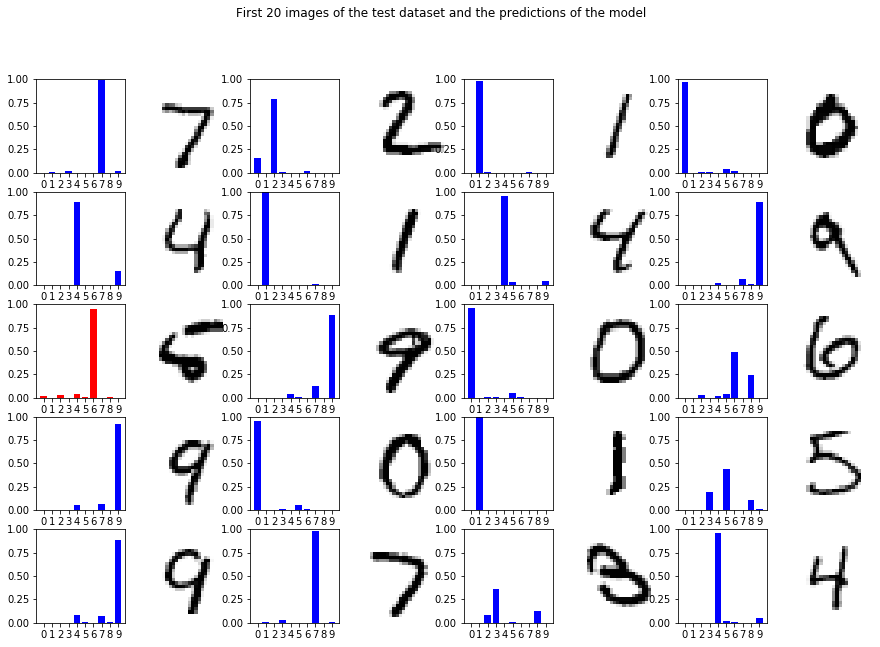

In [42]:
# Batch training with batch size of 60k
test_results = [test_model(test_data, test_labels, np.load('output/5k_batch/wabs_final.npy', allow_pickle=True))]
print('Model accuracy: ' + str(test_results[-1][2]*100) + '%')
plot_results(test_data[0:20], test_results[-1][1][0:20], test_results[-1][0][0:20],
             title='First 20 images of the test dataset and the predictions of the model')

Model accuracy: 97.71%


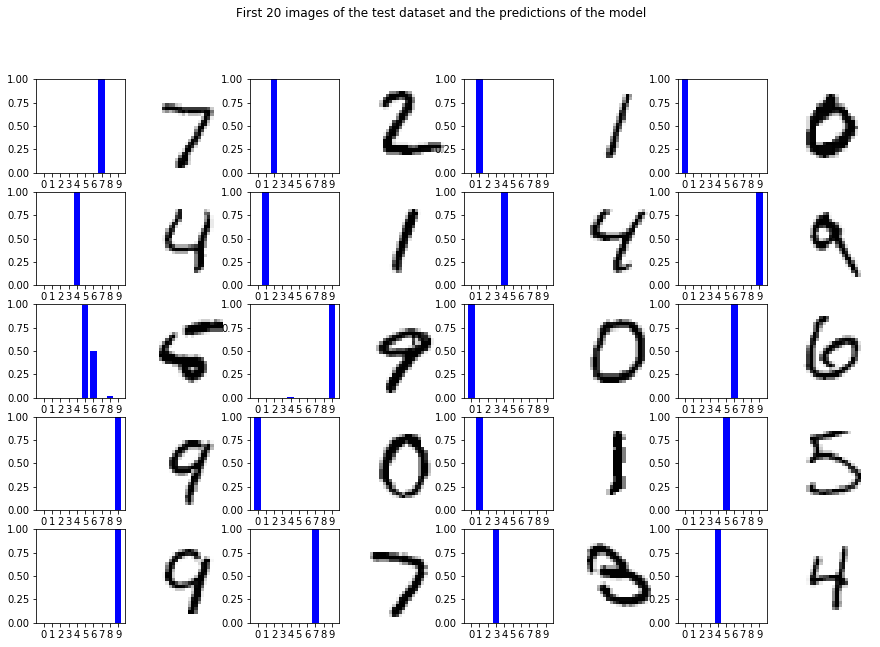

In [44]:
# Batch training with batch size of 100
test_results = [test_model(test_data, test_labels, np.load('output/50_minibatch/wabs_final.npy', allow_pickle=True))]
print('Model accuracy: ' + str(test_results[-1][2]*100) + '%')
plot_results(test_data[0:20], test_results[-1][1][0:20], test_results[-1][0][0:20],
             title='First 20 images of the test dataset and the predictions of the model')